In [ ]:
#| default_exp imitation

# Imitation learning

In [ ]:
#| export 
import numpy as np

In [ ]:
#| hide
from nbdev import show_doc
%load_ext autoreload
%autoreload 2

In [ ]:
#| export

class PS_imitation():
    def __init__(self, 
                 num_states: int, # Number of states 
                 eta: float, # Glow parameter of PS
                 gamma: float # Damping parameter of PS
                ):     
        '''Constructs a PS agent with two actions (continue and rotate) that performs imitation learning 
        in the search scenario. Instead of following a full trajectory of action-state tuples, the agent 
        is directly given the reward state (the step length in this case). The agent updates all previous
        continue actions and the current rotate action.        
        '''
        
        self.num_states = num_states        
        self.eta = eta
        self.gamma_damping = gamma
        
        # h-matrix
        self.h_matrix = np.ones((2, self.num_states)).astype(float)
        # initiate glow matrix
        self.reset()
        
    def reset(self):
        '''Resets the glow matrix'''
        self.g_matrix = np.zeros((2, self.num_states)).astype(float)        
        
        
    def update(self, 
               length: int, # Step length rewarded
               reward: int = 1 # Value of the reward
              ):
        '''
        Updates the policy based on the imitation scheme (see paper for detailes)      
        NOTE: state is length-1 because counter starts in 0 
        (but in 0, agent has already performed a step of length 1 -- from the previous action "rotate").
        '''

        factor = 1 - self.eta
        # ---- Updating the CONTINUE part of g-matrix ---- 
        # Damping before adding up the traversed edges.
        self.g_matrix[0, :length-1] *= (factor**np.arange(1,length))
        # Set to one all previous states (adding up the traversed edges)
        self.g_matrix[0, :length-1] += 1   
        # Multiply by eta**x all previous states
        self.g_matrix[0, :length-1] *= (factor**np.arange(1,length))[::-1]
        # Multiply the rest of the matrix by number of steps don
        self.g_matrix[0, length-1:] *= factor**length

        # ---- Updating the TURN part of g-matrix ---- 
        self.g_matrix[1, :] *= factor**length
        self.g_matrix[1, length-1] += 1

        # Apply damping
        if self.gamma_damping > 0:
            for _ in range(length):
                self.h_matrix -= self.gamma_damping*(self.h_matrix - 1.)

        # Apply reward
        self.h_matrix += self.g_matrix*reward

In [ ]:
show_doc(PS_imitation.update)

---

### PS_imitation.update

>      PS_imitation.update (length:int, reward:int=1)

Updates the policy based on the imitation scheme (see paper for detailes)      
NOTE: state is length-1 because counter starts in 0 
(but in 0, agent has already performed a step of length 1 -- from the previous action "rotate").

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| length | int |  | Step length rewarded |
| reward | int | 1 | Value of the reward |

## Example
We showcase how to imitate the policy based on a given step length distribution, an in particular of a Lévy distribution. For further examples, see the Tutorials section.

In [ ]:
from rl_opts.analytics import pdf_powerlaw, pdf_discrete_sample, get_policy_from_dist
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
NUM_STATES = 100 # size of the state space
EPOCHS = 100 # number of epochs
NUM_STEPS = 1000 # number of learning steps per episode

steps = pdf_discrete_sample(pdf_func = pdf_powerlaw,
                            beta = 1,
                            L = np.arange(1, NUM_STATES),  
                            num_samples = (EPOCHS, NUM_STEPS))

imitator = PS_imitation(num_states = NUM_STATES,
                        eta = int(1e-7),
                        gamma = 0)
    
                               
for e in tqdm(range(EPOCHS)):
    imitator.reset()
    for s in steps[e]:    
        imitator.update(length = s)


100%|██████████| 100/100 [00:01<00:00, 86.11it/s]


In [ ]:
policy_theory = get_policy_from_dist(n_max = NUM_STATES,
                                     func = pdf_powerlaw,
                                     beta = 1)
policy_imitat = imitator.h_matrix[0,:]/imitator.h_matrix.sum(0)

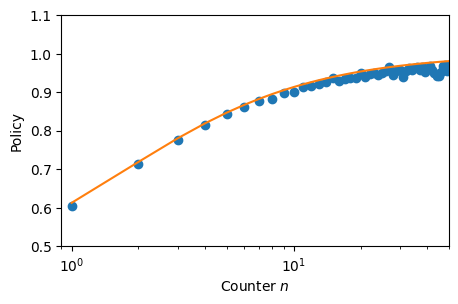

In [ ]:
_ , ax = plt.subplots(figsize = (5,3))
ax.plot(policy_imitat ,'o')
ax.plot(np.arange(1, NUM_STATES), policy_theory[1:])
plt.setp(ax, 
         xscale = 'log', xlim = (0.9, NUM_STATES/2), xlabel = r'Counter $n$',
         ylim = (0.5, 1.1), ylabel = 'Policy');

#| hide
# nbdev

In [ ]:
#| hide
from nbdev import nbdev_export ; nbdev_export()